# [NTDS'18] Final Project: Senator vote predictions based on graph features

## Students

* Team: `7`
* Students: `Mathias Gonçalves, Julien Heitmann, Mathieu Lamiot, Louis Landelle`
* Dataset: `US Senators`

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

#Import distances
from scipy.spatial.distance import squareform

from scipy import sparse
import scipy.sparse.linalg

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from pyunlocbox import functions, solvers
import networkx as nx

import common

## 0 - Loading the data

All the data we load here was retrieved in the first milestone thanks to the dedicated API. Using this API takes some times, hence it is not repeated here and we simply load previously saved files.

* "senators"
* "adjacency" 
* "cosponsored" 
* "DFvote_positions" 
* "DFvotes"

In [2]:
senators = np.load(common.ACTIVE_SENATORS_FNAME)
adjacency = np.load(common.ADJACENCY_FNAME)
cosponsored = pd.read_pickle(common.COSPONSORED_FNAME)
DFvote_positions = pd.read_pickle(common.VOTE_POSITIONS_FNAME)
DFvotes = pd.read_pickle(common.VOTES_FNAME).set_index("id") #explain
DFsenators = pd.DataFrame.from_records(senators).set_index("id") #explain

### Indices ###
vote_ids = DFvotes.index.values
senator_ids = DFsenators.index.values

In [3]:
with open(common.COSPONSORS_FNAME, "rb") as ser_dict:
    cosponsors = pickle.load(ser_dict)

In [4]:
#Convert features to numbers
DFvote_positions = DFvote_positions.replace('Yes',1)
DFvote_positions = DFvote_positions.replace('No',0)

#All others values should be NaN
DFvote_positions = DFvote_positions.apply(pd.to_numeric, errors='coerce')

### Diplay data
First, let's get a first look at the structure of the data. We first get a look at the senators:

In [5]:
senators[:2]

array([{'id': 'A000360', 'title': 'Senator, 2nd Class', 'short_title': 'Sen.', 'api_uri': 'https://api.propublica.org/congress/v1/members/A000360.json', 'first_name': 'Lamar', 'middle_name': None, 'last_name': 'Alexander', 'suffix': None, 'date_of_birth': '1940-07-03', 'gender': 'M', 'party': 'R', 'leadership_role': None, 'twitter_account': 'SenAlexander', 'facebook_account': 'senatorlamaralexander', 'youtube_account': 'lamaralexander', 'govtrack_id': '300002', 'cspan_id': '5', 'votesmart_id': '15691', 'icpsr_id': '40304', 'crp_id': 'N00009888', 'google_entity_id': '/m/01rbs3', 'fec_candidate_id': 'S2TN00058', 'url': 'https://www.alexander.senate.gov/public', 'rss_url': 'https://www.alexander.senate.gov/public/?a=RSS.Feed', 'contact_form': 'http://www.alexander.senate.gov/public/index.cfm?p=Email', 'in_office': True, 'dw_nominate': 0.323, 'ideal_point': None, 'seniority': '15', 'next_election': '2020', 'total_votes': 569, 'missed_votes': 26, 'total_present': 0, 'last_updated': '2018-11

The data frame here shows the vote of every participant for every senator for every bill. The bills are the column of the data frame and the index are the 100 senator numbered form 0 to 99. The columns are shown in reverse order since in the original dataframe, the first column is the oldest bill.

In [6]:
DFvote_positions[DFvote_positions.columns[::-1]] #reverse column order, most recent votes first

,C115:S2:C99,C115:S2:C98,C115:S2:C97,C115:S2:C96,C115:S2:C95,C115:S2:C94,C115:S2:C93,C115:S2:C92,C115:S2:C91,C115:S2:C90,...,C111:S2:C109,C111:S2:C108,C111:S2:C107,C111:S2:C106,C111:S2:C105,C111:S2:C104,C111:S2:C103,C111:S2:C102,C111:S2:C101,C111:S2:C100
0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DFvotes contains all the information about every bill. The bill are in the index:

In [7]:
DFvotes

,amendment.api_uri,amendment.number,amendment.sponsor,amendment.sponsor_id,amendment.sponsor_party,amendment.sponsor_state,amendment.sponsor_uri,bill.bill_id,bill.bill_uri,bill.latest_action,...,question,result,roll_call,session,time,total.no,total.not_voting,total.present,total.yes,vote_uri
id,,,,,,,,,,,,,,,,,,,,,
C115:S2:C274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion to Proceed,Motion to Proceed Agreed to,274,2,12:31:00,47,6,0,47,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion,Motion Agreed to,273,2,21:30:00,21,8,0,71,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn2209-115,NaN,NaN,...,On the Cloture Motion,Cloture Motion Agreed to,272,2,11:22:00,1,4,0,95,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Motion,Motion Agreed to,271,2,20:22:00,12,1,0,87,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C270,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,270,2,20:02:00,62,1,0,37,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C269,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,269,2,19:43:00,66,1,0,33,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C268,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,268,2,19:01:00,67,1,0,32,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Cloture Motion,Cloture Motion Agreed to,267,2,17:22:00,12,6,0,82,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sjres54-115,https://api.propublica.org/congress/v1/115/bil...,Held at the desk.,...,On the Joint Resolution,Joint Resolution Passed,266,2,15:03:00,41,3,0,56,https://api.propublica.org/congress/v1/115/sen...


DFsenators senator contains all the information about every senators:

In [9]:
DFsenators

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state_rank,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
id,,,,,,,,,,,,,,,,,,,,,
A000360,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,senior,None,"Senator, 2nd Class",0,569,SenAlexander,https://www.alexander.senate.gov/public,97.05,15691,lamaralexander
B001230,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.522,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,junior,None,"Senator, 1st Class",1,569,SenatorBaldwin,https://www.baldwin.senate.gov,94.17,3470,witammybaldwin
B001261,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.533,johnbarrasso,202-224-1724,S6WY00068,John,...,junior,None,"Senator, 1st Class",0,569,SenJohnBarrasso,https://www.barrasso.senate.gov,96.65,52662,barrassowyo
B001267,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.207,senbennetco,202-228-5097,S0CO00211,Michael,...,senior,None,"Senator, 3rd Class",1,569,SenBennetCo,https://www.bennet.senate.gov,90.25,110942,SenatorBennet
B001277,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.423,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,senior,None,"Senator, 3rd Class",1,569,SenBlumenthal,https://www.blumenthal.senate.gov,90.81,1568,SenatorBlumenthal
B000575,https://api.propublica.org/congress/v1/members...,https://www.blunt.senate.gov/public/index.cfm/...,N00005195,45465,1950-01-10,0.430,SenatorBlunt,202-224-8149,S0MO00183,Roy,...,junior,None,"Senator, 3rd Class",0,569,RoyBlunt,https://www.blunt.senate.gov/public,98.20,418,SenatorBlunt
B001288,https://api.propublica.org/congress/v1/members...,https://www.booker.senate.gov/?p=contact,N00035267,84679,1969-04-27,-0.612,None,202-224-8378,S4NJ00185,Cory,...,junior,None,"Senator, 2nd Class",1,569,CoryBooker,https://www.booker.senate.gov,84.10,76151,SenCoryBooker
B001236,https://api.propublica.org/congress/v1/members...,https://www.boozman.senate.gov/public/index.cf...,N00013873,92069,1950-12-10,0.401,JohnBoozman,202-228-1371,S0AR00150,John,...,senior,None,"Senator, 3rd Class",0,569,JohnBoozman,https://www.boozman.senate.gov/public,98.23,27958,BoozmanPressOffice
B000944,https://api.propublica.org/congress/v1/members...,http://www.brown.senate.gov/contact/,N00003535,5051,1952-11-09,-0.438,None,202-228-6321,S6OH00163,Sherrod,...,senior,None,"Senator, 1st Class",1,569,SenSherrodBrown,https://www.brown.senate.gov,93.47,27018,SherrodBrownOhio


## 1 - First Feature: 2nd Laplacian eigenvector

In the following, we summarize what we found out during milestone 3. Laplacian eigenmaps of the network based on the votes of each senators provides a nice way of clustering senators that can be interpreted as their party. As we will see, it provides a powerful feature for our classifier as it already achieves good performances with only one feature coming from the 2nd dimension of the Laplacian eigenmaps.

First, let's review the graph we will use in this section. Each node is a senator and edges/weights are generated from 'DFvote_positions': for each pair of senator, we computed a distance based on their votes in common (cf. milestone 1). The graph we obtained is the presented below. It is strongly clustered into two parts, that are actually the parties (democrats and republicans).

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


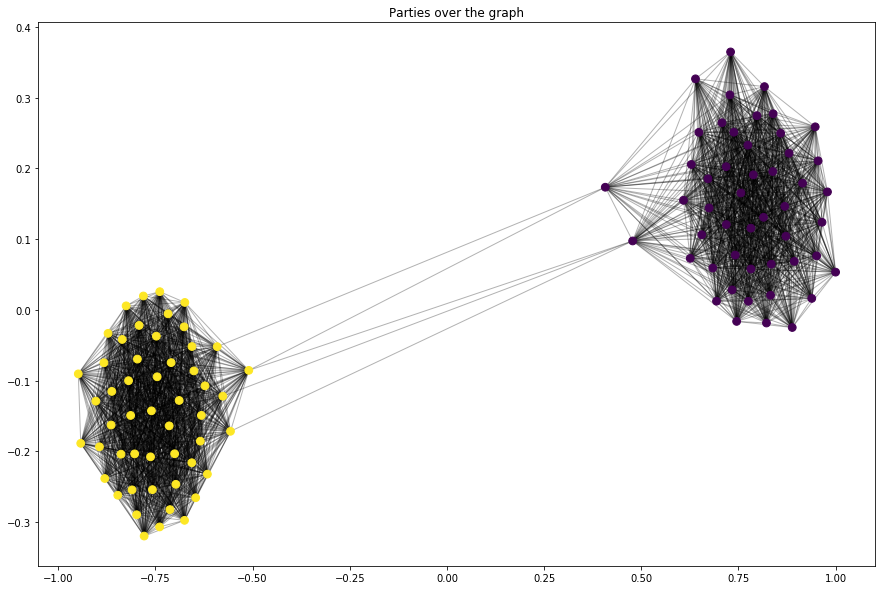

In [10]:
party = np.array([s["party"] for s in senators])
party_for_graph = (((party == 'R')*1)-0.5)*2

#Display the graph and the parties
graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adjacency))
coords = nx.spring_layout(graph)  # Force-directed layout.
plt.figure(figsize= (15,10))
plt.subplot(111)
plt.title("Parties over the graph")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=party_for_graph)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

Even if Republicans/Democrats could be a good feature to begin with, it seems that some senators are strongly coherent with their party whereas some other are a bit "in-between". Hence, a binary feature might not capture exactly the phenomenon.

In order to get a good measure of affiliation with the party, we will have a deeper look into the laplacian eigenmaps, as suggested in milestone 3.

In [11]:
# Create the Laplacian
degree_vect = np.sum(adjacency,axis=1)
degree_matrix = np.diag(degree_vect)
laplacian = degree_matrix-adjacency
laplacian_csr = sparse.csr_matrix(laplacian)
# Compute eigenvectors using sparse laplacian - Missing the last eigenvalue
d = 8
eig_val, eig_vect = sparse.linalg.eigsh(laplacian_csr, k=d, which = 'SM')
fiedler = eig_vect.T[1] # Fiedler vector

Here, the first 8 eigenvector are plotted to try to find if any of them gives a good amount of information from the covoting graph:

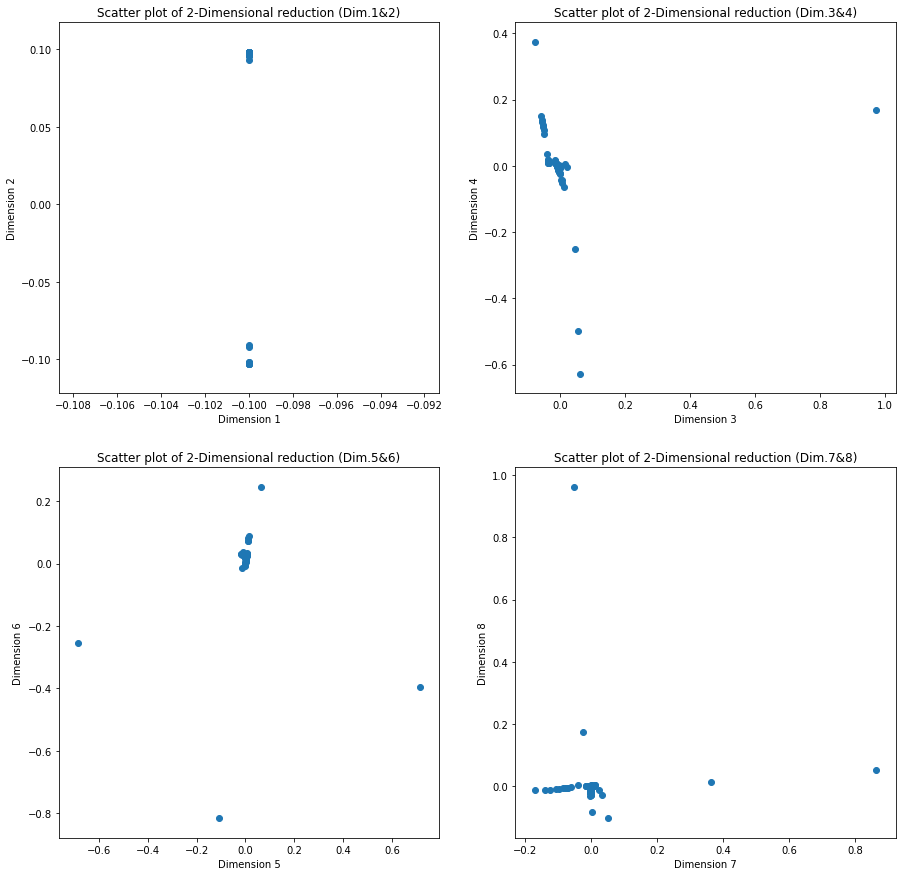

In [12]:
plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,0], eig_vect[:,1])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&2)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.subplot(222)
plt.scatter(eig_vect[:,2], eig_vect[:,3])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.3&4)")
plt.xlabel("Dimension 3")
plt.ylabel("Dimension 4")

plt.subplot(223)
plt.scatter(eig_vect[:,4], eig_vect[:,5])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.5&6)")
plt.xlabel("Dimension 5")
plt.ylabel("Dimension 6")

plt.subplot(224)
plt.scatter(eig_vect[:,6], eig_vect[:,7])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.7&8)")
plt.xlabel("Dimension 7")
plt.ylabel("Dimension 8")
plt.show()

As we can see, the dimensions 2, 4 and 7 seem to be the most relevant to separate the senators. Other dimensions lead to the separation of one (or a couple) of senators only which means they are likely not to be useful. Let's see if those three dimensions are actually useful.
We add to the following plots colors depending on the party of each senator (republicans and democrats) to try and interpret those dimensions.

Text(0, 0.5, 'Dimension 7')

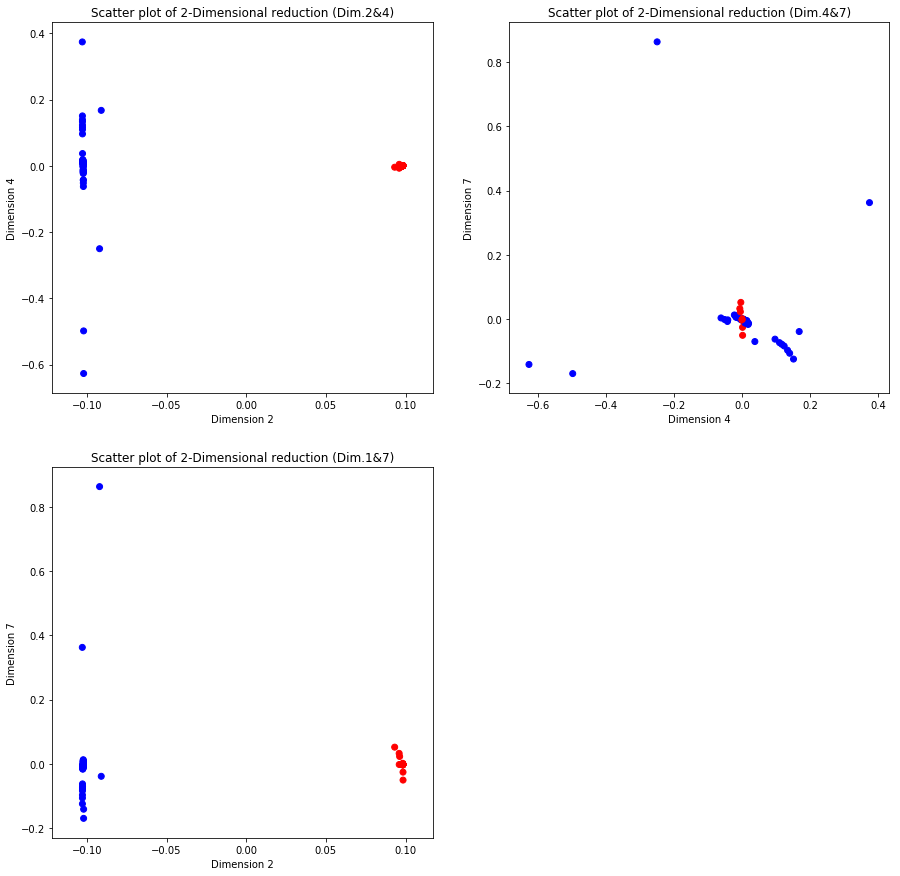

In [13]:
#Generate a colormap based on the party of each senator
color_map = np.repeat('b', party.size)
color_map[party == 'R'] = 'r'


plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,1], eig_vect[:,3],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.2&4)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 4")


plt.subplot(222)
plt.scatter(eig_vect[:,3], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.4&7)")
plt.xlabel("Dimension 4")
plt.ylabel("Dimension 7")


plt.subplot(223)
plt.scatter(eig_vect[:,1], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&7)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 7")

Dimensions 4 and 7 seem to seperate only a few senators from the others, hence they are probably not a useful general feature. Notice that dimension 2 is strongly linked to the party of the senator and separate republicans from democrats. Hence, this dimension is particularly interesting as it can be easily interpreted. No specific interpretations were found for the other dimensions.
Thanks to this observation, we will use dimension 2 as a feature for our classifier: As each vote is introduced by a person affiliated to a party, our feature will be the distance of a senator to the party linked to the vote (Republican = 0.1, Democrats = -0.1) along that 2nd dimension of the eigenmaps.

In [14]:
def feature_laplacian_eigen_dim2(fiedler, df_votes, senator_id_num, vote_id):
    
    #Retrieve the feature of the senator
    senatorLoc = fiedler[senator_id_num]
    voteParty = df_votes.loc[vote_id, "amendment.sponsor_party"]
    
    if voteParty == 'D':
        voteLoc = -0.1
        #print("D")
    elif voteParty[0] == 'R':
        voteLoc = 0.1
        #print("R")
    else:
        voteLoc = senatorLoc #In this case, we want the feature not to count
    
    #Compute the distance between the two features to be used as a new feature
    distance = abs(voteLoc-senatorLoc)
    
    return distance 

## 2 - Second feature: Cosponsorship

The bills that are voted by the senator at the congress are often sponosored some senaotors. From there it was believed that is 2 senators are sponsoring the same laws they are very likely to vote the same way. So we are defining a graph that links the senator this time not using how much vote in common they have but using the number of co-cosponsored bills they have between each other.

In [15]:
def jaccard_similarity(list1, list2):
    """
    Computes the ration between the cardinallity of the intersection and the union of two set
    """
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

The weight in the graph between two senators is defined as the jaccard index or jaccard similarity between their set of sponsored bills. Here, the graph is built and the histogram of the weight is plotted:

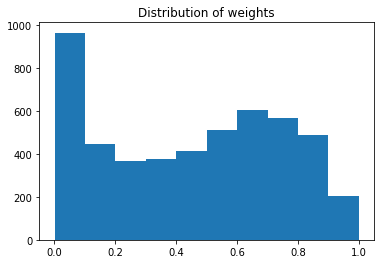

In [16]:
#Generate a graph based on cosponsored bills
n_senators = len(senators)
cospons_mat = np.zeros((n_senators, n_senators))

#Compute the weights between senators: a distance based on the cosponsorship feature
senator_pairs = ((i, j, x, y) for i, x in enumerate(senators) for j, y in enumerate(senators) if not x["id"] == y["id"])

for i, j, s1, s2 in senator_pairs:
    
    #common_bills = set(cosponsored[s1["id"]]).intersection(cosponsored[s2["id"]])
    #commonality = len(common_bills) / 20. 
    commonality = jaccard_similarity(cosponsored[s1["id"]], cosponsored[s2["id"]])
    cospons_mat[i, j] = commonality
    cospons_mat[j, i] = commonality

#From the feature differences, build distances and weights    
cospons_vect = squareform(cospons_mat)
kernel_width = cospons_vect.mean()
weights_vect = np.exp(-cospons_vect**2 / kernel_width**2)

#Visualize the weights distribution to assign a treshold
plt.hist(weights_vect)
plt.title('Distribution of weights')
plt.show()

Next, we threshold the weight because we consider that the senators that have low co-sponsorship are not linked at all.

In [17]:
#Treshold the matrix
weights_threshold = 0.6
adjacency_cospons = squareform(weights_vect)
adjacency_cospons[adjacency_cospons < weights_threshold] = 0 

Then we display the adjacency matrix of the graph:

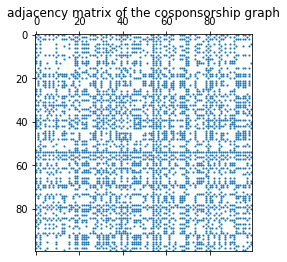

In [18]:
plt.spy(adjacency_cospons, markersize=1)
plt.title('adjacency matrix of the cosponsorship graph')
plt.show()

Finally the graph is ploted using the spring layout:

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


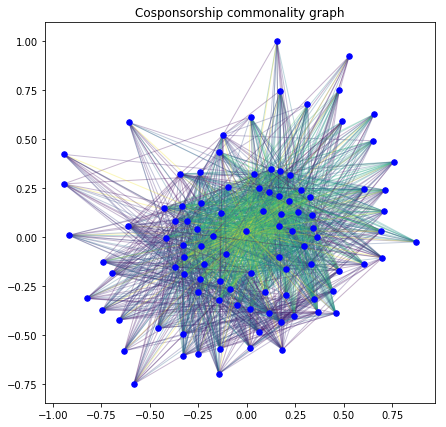

In [19]:
graph_cospons = nx.from_numpy_matrix(adjacency_cospons)
coords_cospons = nx.spring_layout(graph_cospons)

_, weights_cospons = zip(*nx.get_edge_attributes(graph_cospons,'weight').items())

plt.figure(figsize= (7,7))
plt.subplot(111)
plt.title("Cosponsorship commonality graph")
nx.draw_networkx_nodes(graph_cospons, coords_cospons, node_size=30, node_color='b')
nx.draw_networkx_edges(graph_cospons, coords_cospons, alpha=0.3, edge_color=weights_cospons, width=1)
plt.savefig("Co-spo-graph.png")
plt.show()

The commented method is the method used to get the list of senator sponsoring the bill given in argument. And the second method is the function called to generate the feature that will be used by the classifiers:

In [20]:
"""
def get_cosponsors_num_id(cosponsors, vote_id):
    
    #Retrieve the bill we are considering in the Dataframe
    DFbill = DFvotes[DFvotes["id"]==voteID]
    #Get its bill id (Bill id + congress number)
    DFbill_id = list(DFbill["bill.bill_id"])
    
    bill_id = DFbill_id[0]
    
    # Some of the DFbill["bill.bill_id"] entries are NaNs so we just skip them
    if not isinstance(bill_id, str):
        return []
    
    bill_id = bill_id.split("-")
    #Retrieve the cosponsors from the API
    ans = _get(URL_COSPONS_BILL(bill_id[0], bill_id[1]), verbose=False)
    if ans["status"]=="OK":
        cosponsors = ans["results"][0]["cosponsors"]
        cosponsors_id = [cosponsor["cosponsor_id"] for cosponsor in cosponsors]
        
        DFcosponsors = DFsenators[DFsenators["id"].isin(cosponsors_id)]
        cosponsors_num = list(DFcosponsors["id_num"])
        
        
    else:
        cosponsors_num = []
    return cosponsors_num
"""

def feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num):
    distances = adjacency_cospons[senator_id_num, cosponsors_num]
    distance = np.sum(distances)
    
    return distance 

## 3 - Alternative features from graphs: Distances 

In this part, we will keep on working on the same graph. We will work on several ways of computing a distance from one senator to a law and use those distances as features for the final classification.


The first distance we can use is the shortest path distance between one senator and  the co-sponsors of the law. Note that the distance can be computed on all the graph we have.

In [21]:
def feature_shortest_path(senatorID,cosponsors, graph):
    min_distance = np.inf #We are only interested in the smallest distance
    for cosponsor in cosponsors: #We compute for each cosponsor the minimum distance to the senator.
        #Compute shortest path
        path =  nx.shortest_path(graph, source=senatorID, target=cosponsor, weight = zip(*nx.get_edge_attributes(graph,'weight').items()))
        #Compute the related distance
        distance = 0
        for k in range(0,len(path)-1):
            edge_weight = graph[path[k]][path[k+1]]
            distance = distance + 1/edge_weight['weight'] #Distance is the inverse of the weight !
        #compare to the minimum distance we already have
        min_distance = np.minimum(distance,min_distance)
    return distance

In the previous distance, we only take the shortest path into account. But maybe a senator is linked to another one through many different paths, which connects them more than if they were only connected by their smallest path. In order to take into account the entire graph in the computation of the distance, we will use the heat kernel: The idea is that if one senator sponsors a law, he could advertize it through his direct network, and diffuse the information. The time it takes to that information to diffuse to other senators could be a good measurment of how linked are two senators. The following distance is based on that diffusion principle:

In [22]:
#The following functions are adapted from milestone 3
def GFT(x,U):
    y = U.T.dot(x)
    return y 
def iGFT(x,U):
    y = U.dot(x)
    return y
def heat_kernel(e, t):
    return np.exp(-t*e)
def graph_filter(x, kernel, U, **kwargs):
    return iGFT(kernel*GFT(x,U),U)

#This is the new distanec we use
def feature_heat_kernel_distance(senatorID, cosponsors, graph, threshold, step):
    up_count = 200
    #Compute the eigenvectors for the GFT
    e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
    #Generate diracs at each cosponsor location
    f_in = np.zeros(100)
    f_in[cosponsors] = 1
    
    #Advance in time up until the desired heat is obtained at the target location
    t = 0
    count = 0
    f_out = f_in
    while(f_out[senatorID]<threshold*len(cosponsors) and count < up_count ):
        t = t + step
        count = count + 1 
        f_out = graph_filter(f_out, heat_kernel(e, step), U)
        f_out[cosponsors] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    return t     

2.0000000000000013


/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


2.389999999999993


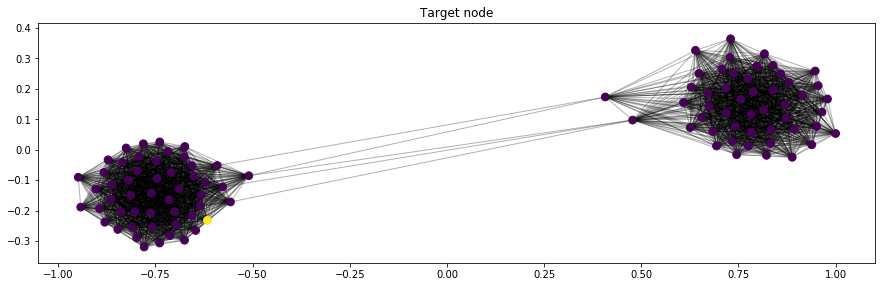

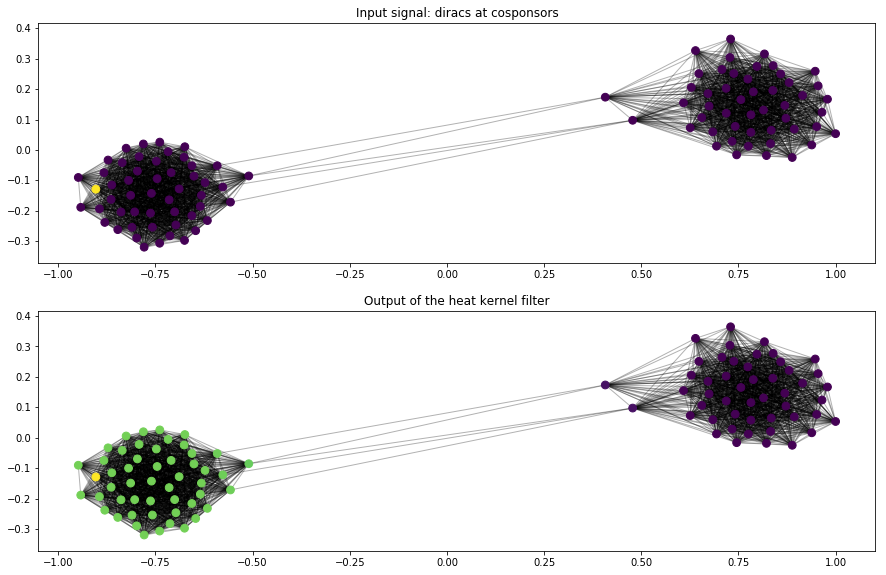

In [23]:
#Example
cosponsors_ex = [70]
e, U = scipy.linalg.eigh(nx.laplacian_matrix(graph).todense())
#Retrieve the distance
t = feature_heat_kernel_distance(5, cosponsors_ex, graph, 0.8, 0.01)
print(t)
#Illustrate the initial signal, and the signal after diffusion during time t
f_in = np.zeros(100)
f_in[cosponsors_ex] = 1

f_tar = np.zeros(100)
f_tar[5] = 1


#Plot
plt.figure(figsize= (15,15))
plt.subplot(311)
plt.title("Target node")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_tar)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.figure(figsize= (15,15))
plt.subplot(312)
plt.title("Input signal: diracs at cosponsors")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_in)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

f_out = f_in
t = 0
while(f_out[5]<0.8*len(cosponsors_ex)):
    t = t + 0.01
    f_out = graph_filter(f_out, heat_kernel(e, 0.01), U)
    f_out[cosponsors_ex] = 1 #We assume that the heat generated at cosponsors is constant: they behave like heaters and don't lose their "heat" (ie. conviction in favor of the law)
    
print(t)
plt.subplot(313)
plt.title("Output of the heat kernel filter")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=f_out)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

## 4- Third feature: Committees

Another way to group senators is through the system of congressional commitees. A congressional committee is a sub-organization that handles a specific duty. Committee membership enables members to develop specialized knowledge of the matters under their jurisdiction. Congressional committees provide valuable informational services to Congress by investigating and reporting about specialized subjects, allowing for informed legislation.

Committees are of two forms in the senate: 
- "standing" commmittees
- "special" or "select" committees

There exists a third type of committee, bicameral, thus also grouping senators:
- "joint" committees

We fetch all standing and special committees from the API to get a list from their URIs, among other info.

In [24]:
DFvotes

,amendment.api_uri,amendment.number,amendment.sponsor,amendment.sponsor_id,amendment.sponsor_party,amendment.sponsor_state,amendment.sponsor_uri,bill.bill_id,bill.bill_uri,bill.latest_action,...,question,result,roll_call,session,time,total.no,total.not_voting,total.present,total.yes,vote_uri
id,,,,,,,,,,,,,,,,,,,,,
C115:S2:C274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion to Proceed,Motion to Proceed Agreed to,274,2,12:31:00,47,6,0,47,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr695-115,https://api.propublica.org/congress/v1/115/bil...,Considered by Senate (Message from the House c...,...,On the Motion,Motion Agreed to,273,2,21:30:00,21,8,0,71,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn2209-115,NaN,NaN,...,On the Cloture Motion,Cloture Motion Agreed to,272,2,11:22:00,1,4,0,95,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Motion,Motion Agreed to,271,2,20:22:00,12,1,0,87,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C270,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,270,2,20:02:00,62,1,0,37,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C269,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,269,2,19:43:00,66,1,0,33,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C268,https://api.propublica.org/congress/v1/115/ame...,S.Amdt. 4109 to S.Amdt. 4108,John Kennedy,K000393,R,La.,https://api.propublica.org/congress/v1/members...,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Amendment,Amendment Rejected,268,2,19:01:00,67,1,0,32,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s756-115,https://api.propublica.org/congress/v1/115/bil...,Signed by President.,...,On the Cloture Motion,Cloture Motion Agreed to,267,2,17:22:00,12,6,0,82,https://api.propublica.org/congress/v1/115/sen...
C115:S2:C266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sjres54-115,https://api.propublica.org/congress/v1/115/bil...,Held at the desk.,...,On the Joint Resolution,Joint Resolution Passed,266,2,15:03:00,41,3,0,56,https://api.propublica.org/congress/v1/115/sen...


In [25]:
BILLS_FNAME = os.path.join("data", "bills.json")
def get_bills_committees():
    """ Returns mapping from bill_id to list of committee codes sourcing this bill """
    with open(BILLS_FNAME) as fp:
        bills = json.load(fp)
    return {b["bill_id"] : b["committee_codes"] for b in bills}

bills_uris = [v[1]["bill.bill_uri"] for v in DFvotes.iterrows()][:1]
bills = get_bills_committees()

In [26]:
with open("committee_members.json") as fp:
      committee_members = json.load(fp)

In [27]:
# Fetches the list of senators if it was not already loaded from before
if not "senators" in locals():
    senators = np.load("senatorActiveList.npy")
    print(f"Loaded {len(senators)} active senators.")

In [28]:
def map_senator_to_committees(senators_by_committee):
    committees_by_senator = {}
    for cmt_id, s_id_list in senators_by_committee.items():
        for s_id in s_id_list:
            if not s_id in committees_by_senator:
                committees_by_senator[s_id] = set()
            committees_by_senator[s_id].add(cmt_id)
    return committees_by_senator
        
cmts_by_s = map_senator_to_committees(committee_members)

In [29]:
print("There are", len(cmts_by_s.keys()), "individual senators with membership to >= 1 committee")

There are 98 individual senators with membership to >= 1 committee


In [30]:
# Creates a mapping senator_id -> senator_index in votes_results_matrix (alphabetical order of senator id)
s_ids = [s["id"] for s in senators]
s_index_from_id = {}
for s_index, s_id in enumerate(s_ids):
    s_index_from_id[s_id] = s_index
    
# Creates a function vote which gives the vote of some senator_id in some vote_id
def vote(senator_id,  vote_id):    
    return DFvote_positions[vote_id][s_index_from_id[senator_id]]


In [31]:
def comembership(cmt1, cmt2):
    """
    Computes comembership between two committees
    Args: cmt1, cmt2 : two lists of senatorIDs
    Returns: tuple (#comembers, comembers list)
    """
    s1, s2 = set(cmt1), set(cmt2)
    intersct = s1.intersection(s2)
    return len(intersct), intersct



In [32]:

n_cmts = len(committee_members.keys())

# Creates all pairs of distinct committees, of length |cmts|^2 - |cmts|, along with indexes
cmt_enum_pairs = [(i, j, c1, c2)
    for i, c1 in enumerate(committee_members.values())
    for j, c2 in enumerate(committee_members.values())
    if not c1 == c2]

# Creates cmt comembership graph adj matrix
comember_n_mat = np.zeros((n_cmts, n_cmts))

max_comembership = 0

for i, j, c1, c2 in cmt_enum_pairs:
    curr_comembership = comembership(c1, c2)[0]
    comember_n_mat[i, j] = curr_comembership
    max_comembership = max(max_comembership, curr_comembership)

comember_mat = comember_n_mat / max_comembership


In [33]:
thres = 0.3
comember_mat[comember_mat < thres] = 0


/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


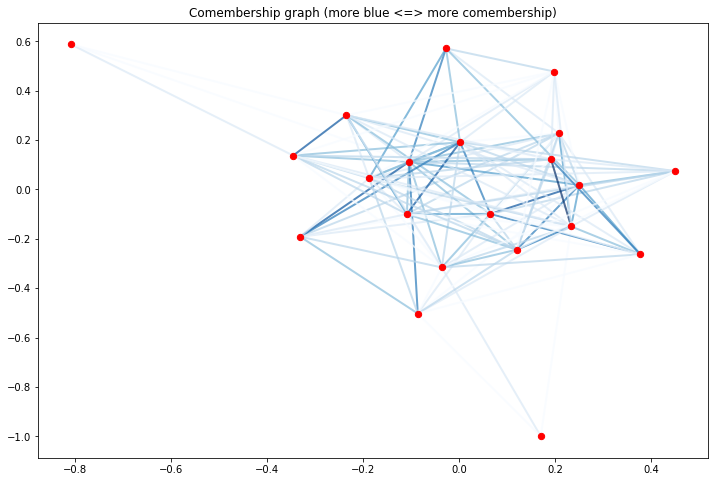

In [34]:
graph_comemb = nx.from_numpy_matrix(comember_mat)
coords_comemb = nx.spring_layout(graph_comemb)

_, weights_comemb = zip(*nx.get_edge_attributes(graph_comemb,'weight').items())

plt.figure(figsize= (12,8))
plt.subplot(111)
plt.title("Comembership graph (more blue <=> more comembership)")
nx.draw_networkx_nodes(graph_comemb, coords_comemb, node_size=40, node_color='r')#, node_color=U[:,0], vmin = 0, vmax= 1)
nx.draw_networkx_edges(graph_comemb, coords_comemb, alpha=0.7, edge_color=weights_comemb, edge_cmap=plt.cm.Blues, width=2)

In [35]:
def shortest_path(cmt_id1, cmt_id2, graph):
    #Compute shortest path
    path =  nx.shortest_path(graph, source=cmt_id1, target=cmt_id2, weight = zip(*nx.get_edge_attributes(graph,'weight').items()))
    #Compute the related distance
    distance = 0
    for k in range(0,len(path)-1):
        edge_weight = graph[path[k]][path[k+1]]
        distance = distance + 1/edge_weight['weight'] #Distance is the inverse of the weight !
    return distance, path

cmt_indices = {c : i for i, c in enumerate(committee_members.keys())}

shortest_path(cmt_indices['SCNC'], cmt_indices['SSCM'], graph_comemb)

(5.833333333333334, [0, 8, 5])

In [37]:
PRINT_STEP = 50
MAX_DISTANCE = np.inf #Think about this

NO_CMT_FOR_SENATOR = 0
NO_CMT_FOR_BILL = 0

min_dist_mat = np.zeros(DFvote_positions.shape)
print(min_dist_mat.shape)
# For every senator...
for sen_i, senator in enumerate(senators):
    # Set the mat to shortest path from closest senator committee to vote committee
    if sen_i % (len(senators) // PRINT_STEP) == 0:
        print(f"{sen_i}/{len(senators)}")
        
    # For each vote...
    for vote_i, col in enumerate(DFvote_positions):
        # Find closest committee and its shortest path to the vote committee
        if not senator["id"] in cmts_by_s:
            NO_CMT_FOR_SENATOR += 1
            min_distance = MAX_DISTANCE
        else:
            # Find the bill_id of this vote
            bill_id = DFvotes["bill.bill_id"][col]
            # Find the committees associated with this bill
            bill_cmts = bills.get(bill_id, [])
            # Remove House committees for associated committees
            bill_senate_cmts = [cmt for cmt in bill_cmts if cmt.startswith('S')]
            if not bill_senate_cmts:
                NO_CMT_FOR_BILL += 1
                min_distance = MAX_DISTANCE
            else:
                shortest_paths = [
                    shortest_path(cmt_indices[senator_cmt_id], cmt_indices[bill_cmt_id], graph_comemb)[0]
                    for senator_cmt_id in cmts_by_s[senator["id"]]
                    for bill_cmt_id in bill_senate_cmts
                ]
                min_distance = min(shortest_paths)            
        
        min_dist_mat[sen_i, vote_i] = min_distance

print("NO_CMT_FOR_SENATOR", NO_CMT_FOR_SENATOR)
print("NO_CMT_FOR_BILL", NO_CMT_FOR_BILL)

(100, 1528)
0/100
2/100
4/100
6/100
8/100
10/100
12/100
14/100
16/100
18/100
20/100
22/100
24/100
26/100
28/100
30/100
32/100
34/100
36/100
38/100
40/100
42/100
44/100
46/100
48/100
50/100
52/100
54/100
56/100
58/100
60/100
62/100
64/100
66/100
68/100
70/100
72/100
74/100
76/100
78/100
80/100
82/100
84/100
86/100
88/100
90/100
92/100
94/100
96/100
98/100
NO_CMT_FOR_SENATOR 3056
NO_CMT_FOR_BILL 122108


One last tweak : we can't use infinity for the shortest path for house bills or committee-less senators, as it is too large a value for the classifier. We also can't use 0 because this is a valid answer when the senator is coming from the same committee pushing the bill. We need to treshold down to a large value, but not too large, the values mapped to infinity in our feature matrix. We will arbitrarely pick twice the maximum valid value currently in our matrix, to represent a large senator/bill committee disconnect.


In [38]:
# Replacing the np.inf with twice the longest shortest path
max_shortest_dist = min_dist_mat[min_dist_mat != np.inf].max()
print("Maximum shortest distance :", max_shortest_dist)
min_dist_mat[min_dist_mat == np.inf] = max_shortest_dist * 2

Maximum shortest distance : 3.75


## 5- Preparing the labels & features

To be able to compute our features we need to make sure that there is at least one senator in the list of cosponsors and that at least one of the two parties actually sponsors the bill. That's why a validity check method was created.

In [39]:
def check_vote_validity(df_votes, vote_id, cosponsors_id):
    valid = False;

    #Check that we have senator cosponsors
    for senator_id in cosponsors_id:
        if senator_id in senator_ids:
            valid = True
    #Check that the vote is affiliated to a party
    vote_party = df_votes.loc[vote_id, "amendment.sponsor_party"]
    valid = valid and (vote_party in ('D','R'))
    
    return valid

This the cell we used to generate the feature list and the labels. As it takes a lot of time tu run you can just skip it and load the data from the saved files: "features_full.npy" and "labels_full.npy" using the next cell. If you still want to use it please uncomment this cell.

In [40]:
# Uncomment in order to run it.

"""
labels = []
features = []

for vote_i, vote_id in enumerate(vote_ids):
    
    print("Working on vote", vote_id)
    bill_id = DFvotes.loc[vote_id, "bill.bill_id"]
    bill_cosponsors = cosponsors.get(bill_id, [])

    
    #Check if the vote will provide valid samples
    if check_vote_validity(DFvotes, vote_id, bill_cosponsors):
        print('Valid law')
        
        cosponsors_num = DFsenators.loc[bill_cosponsors, "id_num"].values #Retrieve cosponsors for that bill
        cosponsors_num = cosponsors_num[~np.isnan(cosponsors_num)]
        cosponsors_num=cosponsors_num.astype(int)
        print(cosponsors_num)
        for senator_i, senator_id in enumerate(senator_ids):
            senator_id_num = DFsenators.loc[senator_id, "id_num"]
            position = DFvote_positions.loc[senator_id_num, vote_id]
            #If this vote actually happened
            if not np.isnan(position):
                #Retrieve all the features for that vote/senator sample
                
                #Feature structure : laplacian_eigen_dim2 (party), ...
                feature = []
                
                #Co-vote features
                feature.append(feature_laplacian_eigen_dim2(fiedler, DFvotes, senator_id_num, vote_id))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph, 0.3, 0.05))
                
                #Cosponsors features
                feature.append(feature_cosponsorship(adjacency_cospons, senator_id_num, cosponsors_num))
                feature.append(feature_shortest_path(senator_id_num,cosponsors_num, graph_cospons))
                feature.append(feature_heat_kernel_distance(senator_id_num, cosponsors_num, graph_cospons, 0.3, 0.05))
               
                #Committee features
                feature.append(min_dist_mat[senator_i, vote_i])

                #Append to the global features list
                labels.append(position)
                features.append(feature)
    else:
        print('Invalid law')
        
features = np.asarray(features)
np.save("features_full.npy",features)
np.save("labels_full.npy",labels)
"""

Working on vote C115:S2:C274
Invalid law
Working on vote C115:S2:C273
Invalid law
Working on vote C115:S2:C272
Invalid law
Working on vote C115:S2:C271
Invalid law
Working on vote C115:S2:C270
Valid law
[96  6 17 71 46 90 65 98 92 80 52 51 16 15 72 93 95 59 83 77 66]
Working on vote C115:S2:C269
Valid law
[96  6 17 71 46 90 65 98 92 80 52 51 16 15 72 93 95 59 83 77 66]
Working on vote C115:S2:C268
Valid law
[96  6 17 71 46 90 65 98 92 80 52 51 16 15 72 93 95 59 83 77 66]
Working on vote C115:S2:C267
Invalid law
Working on vote C115:S2:C266
Invalid law
Working on vote C115:S2:C265
Valid law
[57 66  6 27 95 59 56 30 98  4 34  1 63 80 50 37  8 71]
Working on vote C115:S2:C264
Valid law
[57 66  6 27 95 59 56 30 98  4 34  1 63 80 50 37  8 71]
Working on vote C115:S2:C263
Valid law
[57 66  6 27 95 59 56 30 98  4 34  1 63 80 50 37  8 71]
Working on vote C115:S2:C262
Invalid law
Working on vote C115:S2:C261
Invalid law
Working on vote C115:S2:C260
Invalid law
Working on vote C115:S2:C259
Inval

Working on vote C115:S2:C50
Valid law
[25 41 88 94 18 82 21 76 60 70 58 90 52 51 50 64 71 74  3 42 17  5 13 79
 49 46]
Working on vote C115:S2:C49
Invalid law
Working on vote C115:S2:C48
Invalid law
Working on vote C115:S2:C47
Invalid law
Working on vote C115:S2:C46
Invalid law
Working on vote C115:S2:C45
Invalid law
Working on vote C115:S2:C44
Invalid law
Working on vote C115:S2:C43
Invalid law
Working on vote C115:S2:C42
Invalid law
Working on vote C115:S2:C41
Invalid law
Working on vote C115:S2:C40
Invalid law
Working on vote C115:S2:C39
Invalid law
Working on vote C115:S2:C38
Invalid law
Working on vote C115:S2:C37
Invalid law
Working on vote C115:S2:C36
Invalid law
Working on vote C115:S2:C35
Invalid law
Working on vote C115:S2:C34
Invalid law
Working on vote C115:S2:C33
Invalid law
Working on vote C115:S2:C32
Invalid law
Working on vote C115:S2:C31
Invalid law
Working on vote C115:S2:C30
Invalid law
Working on vote C115:S2:C29
Invalid law
Working on vote C115:S2:C28
Invalid law
W

/Users/Mathias/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


[62 77 12 21 14 23  3 74 17 87  4 99 25 68 98 46 16 64 97  0  7  6 91 11
 71 53 86 75 31 39 42 44  5 22 10 36 58 65 72 51 32 15 29 19 70 76 24 33
 82 52 60 50 41 81 94 93 79  9 37 57 90 88]
Working on vote C115:S1:C145
Valid law
[62 77 12 21 14 23  3 74 17 87  4 99 25 68 98 46 16 64 97  0  7  6 91 11
 71 53 86 75 31 39 42 44  5 22 10 36 58 65 72 51 32 15 29 19 70 76 24 33
 82 52 60 50 41 81 94 93 79  9 37 57 90 88]
Working on vote C115:S1:C144
Valid law
[62 77 12 21 14 23  3 74 17 87  4 99 25 68 98 46 16 64 97  0  7  6 91 11
 71 53 86 75 31 39 42 44  5 22 10 36 58 65 72 51 32 15 29 19 70 76 24 33
 82 52 60 50 41 81 94 93 79  9 37 57 90 88]
Working on vote C115:S1:C143
Invalid law
Working on vote C115:S1:C142
Invalid law
Working on vote C115:S1:C141
Invalid law
Working on vote C115:S1:C140
Invalid law
Working on vote C115:S1:C139
Invalid law
Working on vote C115:S1:C138
Invalid law
Working on vote C115:S1:C137
Invalid law
Working on vote C115:S1:C136
Invalid law
Working on vote C115:S1:

Invalid law
Working on vote C114:S2:C60
Invalid law
Working on vote C114:S2:C59
Invalid law
Working on vote C114:S2:C58
Invalid law
Working on vote C114:S2:C57
Invalid law
Working on vote C114:S2:C56
Invalid law
Working on vote C114:S2:C55
Invalid law
Working on vote C114:S2:C54
Invalid law
Working on vote C114:S2:C53
Invalid law
Working on vote C114:S2:C52
Invalid law
Working on vote C114:S2:C51
Invalid law
Working on vote C114:S2:C50
Invalid law
Working on vote C114:S2:C49
Invalid law
Working on vote C114:S2:C48
Invalid law
Working on vote C114:S2:C47
Invalid law
Working on vote C114:S2:C46
Invalid law
Working on vote C114:S2:C45
Invalid law
Working on vote C114:S2:C44
Invalid law
Working on vote C114:S2:C43
Invalid law
Working on vote C114:S2:C42
Invalid law
Working on vote C114:S2:C41
Invalid law
Working on vote C114:S2:C40
Invalid law
Working on vote C114:S2:C39
Invalid law
Working on vote C114:S2:C38
Invalid law
Working on vote C114:S2:C37
Invalid law
Working on vote C114:S2:C36


Working on vote C112:S2:C109
Invalid law
Working on vote C112:S2:C108
Valid law
[28]
Working on vote C112:S2:C107
Valid law
[28]
Working on vote C112:S2:C106
Valid law
[28]
Working on vote C112:S2:C105
Valid law
[28]
Working on vote C112:S2:C104
Invalid law
Working on vote C112:S2:C103
Invalid law
Working on vote C112:S2:C102
Invalid law
Working on vote C112:S2:C101
Invalid law
Working on vote C112:S2:C100
Invalid law
Working on vote C112:S2:C99
Invalid law
Working on vote C112:S2:C98
Invalid law
Working on vote C112:S2:C97
Invalid law
Working on vote C112:S2:C96
Invalid law
Working on vote C112:S2:C95
Invalid law
Working on vote C112:S2:C94
Invalid law
Working on vote C112:S2:C93
Invalid law
Working on vote C112:S2:C92
Invalid law
Working on vote C112:S2:C91
Invalid law
Working on vote C112:S2:C90
Invalid law
Working on vote C112:S2:C89
Invalid law
Working on vote C112:S2:C88
Invalid law
Working on vote C112:S2:C87
Invalid law
Working on vote C112:S2:C86
Invalid law
Working on vote C1

Working on vote C112:S1:C90
Valid law
[46 63 34 98]
Working on vote C112:S1:C89
Valid law
[46 63 34 98]
Working on vote C112:S1:C88
Invalid law
Working on vote C112:S1:C87
Valid law
[46 63 34 98]
Working on vote C112:S1:C86
Valid law
[46 63 34 98]
Working on vote C112:S1:C85
Invalid law
Working on vote C112:S1:C84
Invalid law
Working on vote C112:S1:C83
Invalid law
Working on vote C112:S1:C82
Invalid law
Working on vote C112:S1:C81
Invalid law
Working on vote C112:S1:C80
Invalid law
Working on vote C112:S1:C79
Invalid law
Working on vote C112:S1:C78
Invalid law
Working on vote C112:S1:C77
Invalid law
Working on vote C112:S1:C76
Invalid law
Working on vote C112:S1:C75
Invalid law
Working on vote C112:S1:C74
Invalid law
Working on vote C112:S1:C73
Invalid law
Working on vote C112:S1:C72
Invalid law
Working on vote C112:S1:C71
Invalid law
Working on vote C112:S1:C70
Invalid law
Working on vote C112:S1:C69
Invalid law
Working on vote C112:S1:C68
Invalid law
Working on vote C112:S1:C67
Inva

Invalid law
Working on vote C111:S2:C60
Valid law
[71 93]
Working on vote C111:S2:C59
Valid law
[71 93]
Working on vote C111:S2:C58
Valid law
[71 93]


In [102]:
# Load the data from the saved files
features = np.load("features_full.npy")
labels = np.load("labels_full.npy")

## 6 - The classifiers

As using a classifier is not at the core of this course, we decided to test two different classifiers:
* A logistic regression classifier
* A Random forest classifier 

Splitting the data into a train set and test set

In [41]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=common.SEED)

Creating and fitting the linear classifier

In [42]:
#Fit the classifier to the data
clf = LogisticRegression(random_state=common.SEED, solver='liblinear')
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2018, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Comparing the test error and the train error for the logistic regresion classifier:

In [43]:
#Compute the percentage of good classifications
score_te = clf.score(x_test, y_test)
score_tr = clf.score(x_train, y_train)
print("LogisticRegressionClassifier test score : " + str(score_te))
print("LogisticRegressionClassifier train score : " + str(score_tr))

LogisticRegressionClassifier test score : 0.731629392971246
LogisticRegressionClassifier train score : 0.7249466950959488


Creating and fitting the random forest classifier

In [58]:
clfrf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=common.SEED)
clfrf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

Comparing the test error and the train error for the random forest classifier:

In [59]:
score_te = clfrf.score(x_test, y_test)
score_tr = clfrf.score(x_train, y_train)
print("RandomForestClassifier test score : " + str(score_te))
print("RandomForestClassifier train score : " + str(score_tr))

RandomForestClassifier test score : 0.8146964856230032
RandomForestClassifier train score : 0.9008528784648188


After comparison of the two classifers the random forest classifer gave better prediction than the logistic regression classifier. The might be due to the fact that the data set is not linearly separable. Further more the 2nd laplacian eigenmap feature is categorical which the random forest classifier is most suitable for.